In [1]:
# import needed libraries

import numpy as np
import string
import patoolib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import email
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Sentiment Analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex


In [2]:
# used patoolib library to unzip the data archiev
#patoolib.extract_archive(r"C:\Users\remoo\OneDrive\Desktop\archive.zip", outdir = r"C:\Users\remoo\OneDrive\Desktop")

**Loading the data**

In [3]:
df = pd.read_csv(r"C:\Users\remoo\OneDrive\Desktop\emails.csv")

In [4]:
df.head()

file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


**Data cleaning and preparing**

In [6]:
# Write functions to extract mail headers and body
def extractmailitems(field, msg):
    elst = []
    
    for i, message in (msg.items()):
        e = email.message_from_string(message)
        elst.append(e.get(field))
       
    return elst


In [7]:
columns = ['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'X-Origin', 'X-Filename']
for i in columns:
    df[i] = extractmailitems(i, df['message'])

In [8]:
def body(col):
    bodycolumn = []
    for message in col.values:
        e = email.message_from_string(message)
        bodycolumn.append(e.get_payload())
 
    return bodycolumn
df['Body'] = body(df['message'])

In [9]:
# extract emplyees' names from file column
def employees(files):
    employees = []
    for i, employee in files.items():
        employee = employee.split('/')[0]
        employees.append(employee)
    return employees
df['Employee'] = employees(df['file'])

In [10]:
df.sample(5)

file  \
295411            love-p/sent_items/75.   
221781      kaminski-v/sent_items/1651.   
193299        jones-t/notes_inbox/4690.   
429614          shackleton-s/sent/6043.   
313010  mann-k/discussion_threads/3012.   

                                                  message  \
295411  Message-ID: <2806758.1075841083940.JavaMail.ev...   
221781  Message-ID: <29637393.1075863414156.JavaMail.e...   
193299  Message-ID: <29902145.1075847447520.JavaMail.e...   
429614  Message-ID: <24804766.1075844922407.JavaMail.e...   
313010  Message-ID: <29307369.1075845827158.JavaMail.e...   

                                         Date                       From  \
295411  Wed, 23 Jan 2002 11:32:57 -0800 (PST)          m..love@enron.com   
221781   Wed, 2 May 2001 18:00:00 -0700 (PDT)   vince.kaminski@enron.com   
193299  Tue, 15 May 2001 06:41:00 -0700 (PDT)        mary.gray@enron.com   
429614  Mon, 16 Apr 2001 01:38:00 -0700 (PDT)  sara.shackleton@enron.com   
313010  Wed, 28 Mar 2001 08:23:00 -0800 (PST)         kay.mann@enron.com   

                                                       To  \
295411                           cecilia.cheung@enron.com   
221781                               anne.labbe@enron.com   
193299  stephanie.sever@enron.com, claudia.clark@enron...   
429614                                       hf20@msn.com   
313010                         reagan.rorschach@enron.com   

                                                  Subject  \
295411  RE: termination list for deals to be moved to ...   
221781                                    Re: Gwen Koepke   
193299                                         Sunoco R&M   
429614                              April 27, 2001 dinner   
313010                                               EMSA   

                                                   X-From  \
295411  Love, Phillip M. </O=ENRON/OU=NA/CN=RECIPIENTS...   
221781                                   Vince J Kaminski   
193299                                    Mary Griff Gray   
429614                                    Sara Shackleton   
313010                                           Kay Mann   

                                                     X-To  \
295411  Cheung, Cecilia </O=ENRON/OU=NA/CN=RECIPIENTS/...   
221781     Anne Labbe <Anne Labbe/ENRON@enronXgate@ENRON>   
193299         Stephanie Sever, Claudia Clark, Tana Jones   
429614                                       hf20@msn.com   
313010                                   Reagan Rorschach   

                                                 X-Folder      X-Origin  \
295411             \ExMerge - Love, Phillip M.\Sent Items        LOVE-P   
221781  \VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...    Kaminski-V   
193299    \Tanya_Jones_June2001\Notes Folders\Notes inbox       JONES-T   
429614  \Sara_Shackleton_Dec2000_June2001_2\Notes Fold...  SHACKLETON-S   
313010  \Kay_Mann_June2001_2\Notes Folders\Discussion ...        MANN-K   

                          X-Filename  \
295411      phillip love 6-25-02.PST   
221781  VKAMINS (Non-Privileged).pst   
193299                    tjones.nsf   
429614                  sshackle.nsf   
313010                     kmann.nsf   

                                                     Body      Employee  
295411  Please let me know when you get close to being...        love-p  
221781  Anne,\n\nThanks for contacting me about this.\...    kaminski-v  
193299  Ladies,\n\nJust checking to see when this cust...       jones-t  
429614  Yes, I will attend (one person).  Thank you.\n...  shackleton-s  
313010  I haven't read this, so I don't know if it is ...        mann-k

In [11]:
# drop unimportant data columns and empty cells
df.drop(columns = ['file', 'message'], inplace=True)
df.dropna(axis = 0, inplace=True)
df.sample(5)

Date                       From  \
222163  Tue, 29 Jan 2002 10:22:03 -0800 (PST)       j.kaminski@enron.com   
491444  Wed, 28 Mar 2001 18:52:00 -0800 (PST)         kim.ward@enron.com   
374180   Mon, 4 Dec 2000 05:50:00 -0800 (PST)   robin.rodrigue@enron.com   
23218   Fri, 10 Mar 2000 12:00:00 -0800 (PST)      greg.nikkel@enron.com   
415288  Mon, 31 Jul 2000 11:07:00 -0700 (PDT)  office.chairman@enron.com   

                              To  \
222163         vkaminski@aol.com   
491444          mreese@cmshq.com   
374180  gabriel.monroy@enron.com   
23218    enron.council@enron.com   
415288   all.worldwide@enron.com   

                                                  Subject  \
222163                    FW: Issues with Exotica Library   
491444                                             oh yo!   
374180                                           Re: Hey!   
23218        Weekly Update on COE SAP Reporting SWAT team   
415288  Organisational Announcement - Introducing Enro...   

                                                   X-From  \
222163  Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...   
491444                                           Kim Ward   
374180                                     Robin Rodrigue   
23218                                         Greg Nikkel   
415288                             Office of the Chairman   

                                             X-To  \
222163                        'vkaminski@aol.com'   
491444                  mreese <mreese@cmshq.com>   
374180                             Gabriel Monroy   
23218   ENRON APOLLO AND BEYOND FINANCIAL COUNCIL   
415288                        All Enron Worldwide   

                                                 X-Folder      X-Origin  \
222163                                \vkamins\Sent Items    KAMINSKI-V   
491444  \KWARD (Non-Privileged)\Ward, Kim S (Houston)\...        Ward-K   
374180         \Robin_Rodrique_Jun2001\Notes Folders\Sent    Rodrique-R   
23218     \Sally_Beck_Dec2000\Notes Folders\All documents        Beck-S   
415288  \Sara_Shackleton_Dec2000_June2001_1\Notes Fold...  SHACKLETON-S   

                          X-Filename  \
222163  vincent kaminski 1-30-02.pst   
491444    KWARD (Non-Privileged).pst   
374180                   rrodri2.nsf   
23218                      sbeck.nsf   
415288                  sshackle.nsf   

                                                     Body      Employee  
222163   \n-----Original Message-----\nFrom: Rajan, Ka...    kaminski-v  
491444  I just got a cheesey email from George Denos -...        ward-k  
374180  I wish you would have sent me this BEFORE I ra...    rodrique-r  
23218   Accomplishments:\nConducted several workshops ...        beck-s  
415288  As evidenced by an exceptionally strong perfor...  shackleton-s

In [12]:
df.Employee.value_counts()[:20]

Employee
kaminski-v      27801
dasovich-j      27463
kean-s          23896
mann-k          23302
jones-t         19739
shackleton-s    18371
taylor-m        13371
farmer-d        12862
germany-c       12267
beck-s          11555
nemec-g         10467
symes-k         10332
scott-s          7788
rogers-b         7760
bass-e           7638
sanders-r        7096
campbell-l       6085
guzman-m         6030
shapiro-r        5872
lenhart-m        5832
Name: count, dtype: int64

In [13]:
# changing the date format and type from string to date object
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)

C:\Users\remoo\AppData\Local\Temp\ipykernel_11688\2007279768.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)


In [14]:
# creating a year column from the date column
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [15]:
df.Year.value_counts()

Year
2001    256402
2000    192904
2002     34782
1999     10896
1980       316
1998       166
2004        70
2044         3
2020         2
1986         2
2007         1
2005         1
1997         1
2043         1
Name: count, dtype: int64

In [16]:
# a function for cleaning text in columns

def extract(col):
    regcol = []
    for sent in col.values:
        
        if str(sent).startswith('<'):  
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))           
            
        elif re.match(r'^\d+', str(sent)):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[0-9]+\'?-?', str(reg))
           
        else:
            reg = re.split(r'@|<|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))
            
        reg = re.sub(r'[\'\",]', '', str(reg))
        regcol.append(str(reg.strip('[]')))
           
            
    return regcol

In [17]:
df['X-From'] = extract(df['X-From'])
df['X-To'] = extract(df['X-To'])

In [18]:
df['X-From'].value_counts()[:20]

X-From
Kay Mann               16314
Vince J Kaminski       14329
Jeff Dasovich           9715
Enron Announcements     8577
Tana Jones              8065
Sara Shackleton         7950
Chris Germany           7298
Steven J Kean           6211
Schedule Crawler        6179
Kate Symes              5223
Eric Bass               4861
Matthew Lenhart         4712
Sally Beck              3868
Debra Perlingiere       3647
Drew Fossum             3622
Carol St Clair          3544
Benjamin Rogers         3311
Gerald Nemec            3244
Richard B Sanders       3209
Phillip M Love          3107
Name: count, dtype: int64

In [19]:
df['X-To'].value_counts()[:20]

X-To
pete davis             5337
vkaminski              4749
Tana Jones             4587
Davis Pete             3821
Jeff Dasovich          3669
Sara Shackleton        3378
All Enron Worldwide    3324
Vince J Kaminski       3321
Kate Symes             3211
Steven J Kean          3086
Mark Taylor            2732
Kay Mann               2380
Daren J Farmer         2292
Kitchen Louise         2208
Gerald Nemec           1986
All Enron Houston      1956
Sally Beck             1912
Suzanne Adams          1786
klay                   1533
Benjamin Rogers        1369
Name: count, dtype: int64

In [20]:
df.sample(5)

Date                    From  \
193986 2000-06-13 09:15:00+00:00    john.moran@enron.com   
515179 2001-05-02 19:39:00+00:00  paul.y'barbo@enron.com   
255674 2002-01-17 16:58:56+00:00    kam.keiser@enron.com   
141090 2001-11-27 18:00:06+00:00      feedback@intcx.com   
345123 2000-11-06 04:22:00+00:00  steve.hooser@enron.com   

                              To  \
193986   samantha.boyd@enron.com   
515179  claugus@worldnet.att.net   
255674    tracey.irvin@enron.com   
141090   gasindex@list.intcx.com   
345123    gerald.nemec@enron.com   

                                              Subject  \
193986                 Re: Counterparty Approval List   
515179                                   Cliff Baxter   
255674                              RE: Book requests   
141090                                    Gas Indices   
345123  Re: EOL Transport GTC and Product Description   

                          X-From           X-To  \
193986                John Moran  Samantha Boyd   
515179              Paul Y Barbo        claugus   
255674                Keiser Kam   Irvin Tracey   
141090  IntercontinentalExchange       gasindex   
345123          Steve Van Hooser   Gerald Nemec   

                                                 X-Folder    X-Origin  \
193986     \Tanya_Jones_Dec2000\Notes Folders\Notes inbox     JONES-T   
515179            \Y'Barbo, Paul\Y'Barbo, Paul\Sent Items    YBARBO-P   
255674                  \ExMerge - Keiser, Kam\Sent Items    KEISER-K   
141090  \JGRIFFIT (Non-Privileged)\Griffith, John\Dele...  Griffith-J   
345123  \Gerald_Nemec_Dec2000_June2001_1\Notes Folders...     NEMEC-G   

                           X-Filename  \
193986                     tjones.nsf   
515179              Y'Barbo, Paul.pst   
255674         kam keiser 7-11-02.PST   
141090  JGRIFFIT (Non-Privileged).pst   
345123                     gnemec.nsf   

                                                     Body    Employee  Year  
193986  Samantha\n\nI don't think this is meant for me...     jones-t  2000  
515179  ED,\n\nI'm sure that you already knew this but...    ybarbo-p  2001  
255674       \nThis should help you.\n\nKam\n3-5781\n\...    keiser-k  2002  
141090  \n\n                                          ...  griffith-j  2001  
345123  Gerald,\n\nI finally got a chance to review th...     nemec-g  2000

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495547 entries, 0 to 517400
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Date        495547 non-null  datetime64[ns, UTC]
 1   From        495547 non-null  object             
 2   To          495547 non-null  object             
 3   Subject     495547 non-null  object             
 4   X-From      495547 non-null  object             
 5   X-To        495547 non-null  object             
 6   X-Folder    495547 non-null  object             
 7   X-Origin    495547 non-null  object             
 8   X-Filename  495547 non-null  object             
 9   Body        495547 non-null  object             
 10  Employee    495547 non-null  object             
 11  Year        495547 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(1), object(10)
memory usage: 47.3+ MB


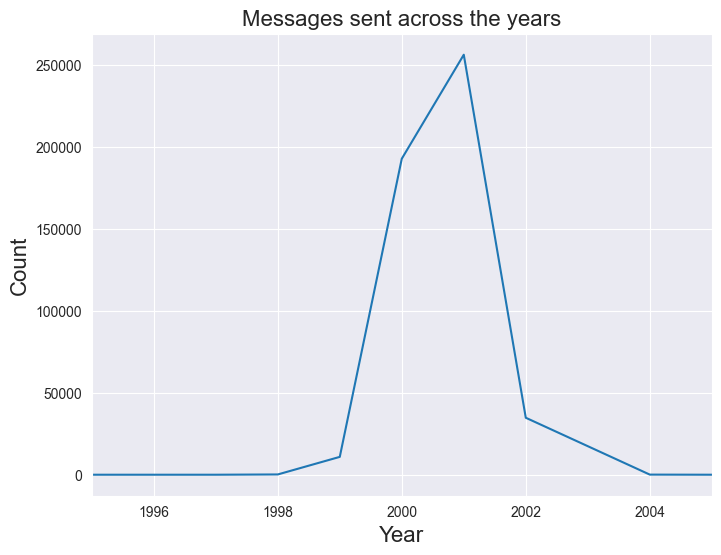

In [22]:
# make a diagram to show the count of messages sent per year
ax = df.groupby(df.Year)['X-Origin'].count().plot(figsize = (8,6))
ax.set_xlim(1995,2005)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.set_title('Messages sent across the years', fontsize = 16)
plt.show()

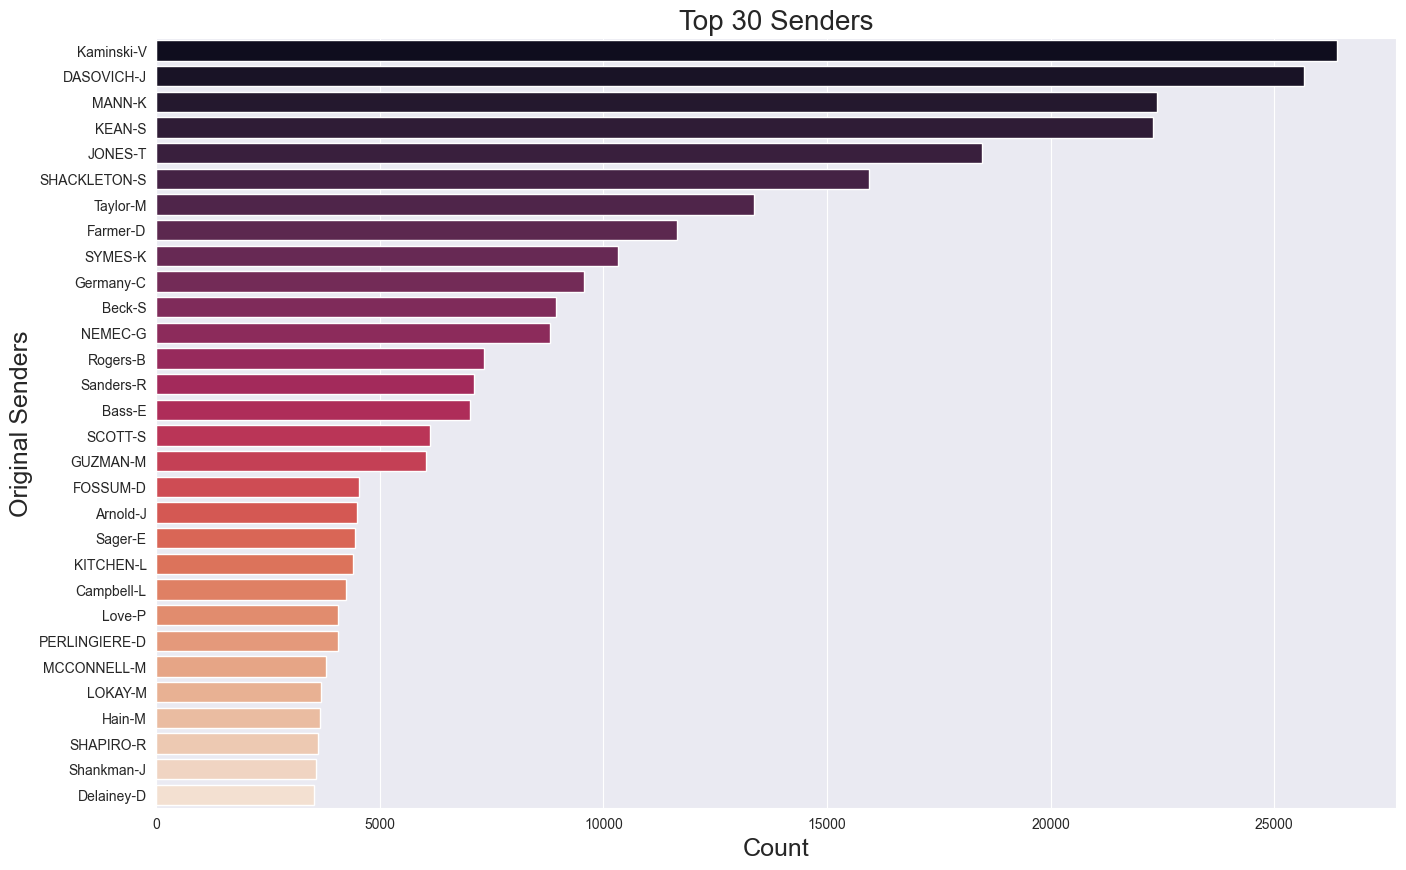

In [23]:
# diagram for showing top senders
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['X-Origin'].value_counts().values[:30], y = df['X-Origin'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Original Senders', fontsize = 18)
ax.set_title('Top 30 Senders', fontsize = 20)
plt.show()

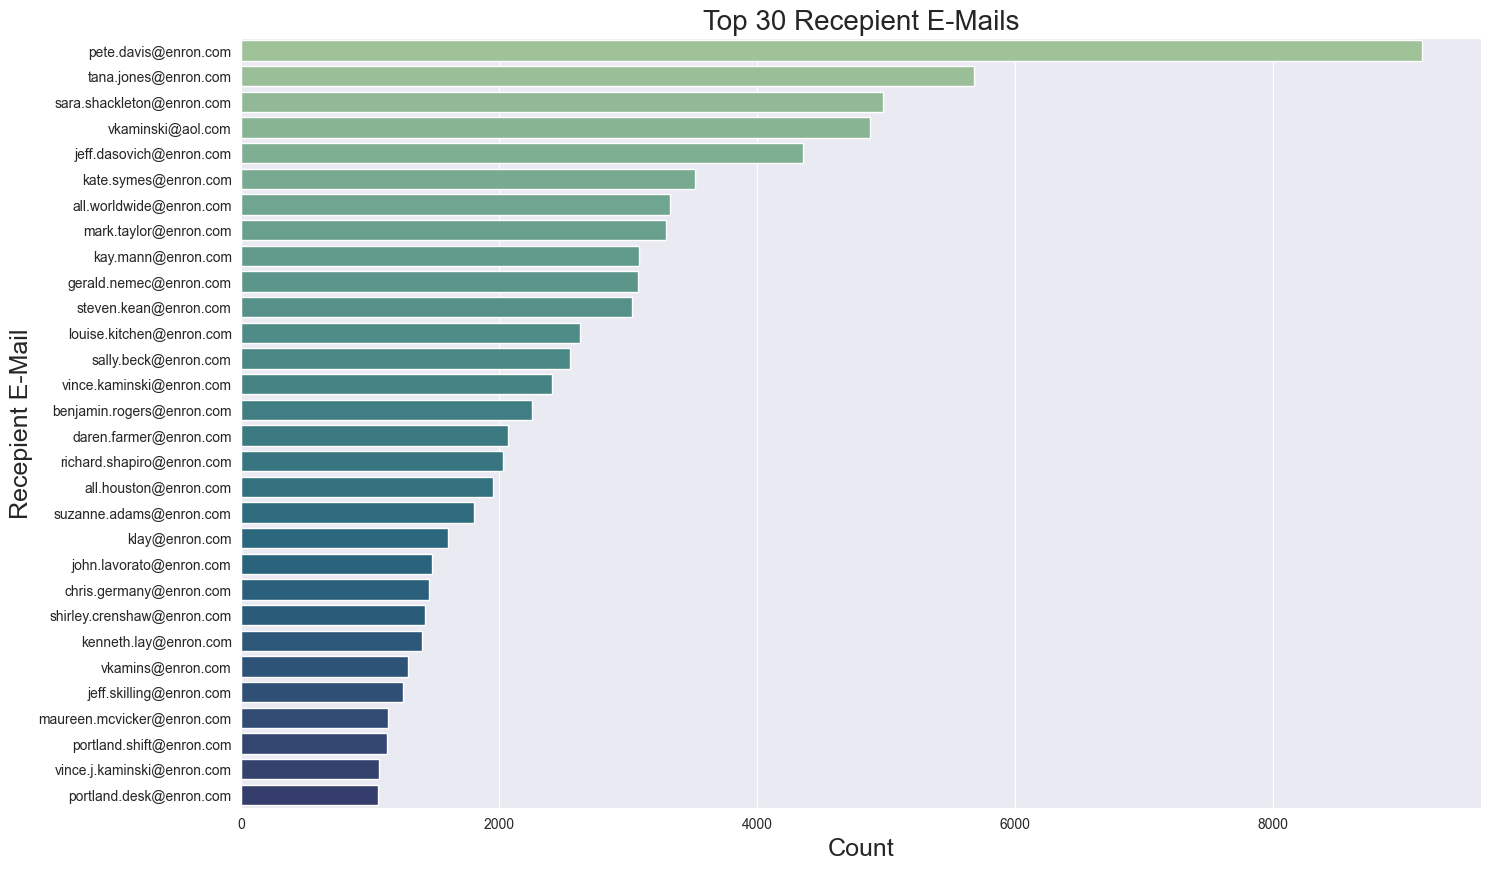

In [24]:
# diagram showing top recepients
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['To'].value_counts().values[:30], y = df['To'].value_counts().keys()[:30] ,palette = 'crest', orient = 'h')
# ax = df['To'].value_counts()[:30].sort_values(ascending = True).plot(kind = 'barh', figsize = (10,8), color= 'dodgerblue')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

In [26]:
userlist = df['X-Origin'].unique()

In [27]:
useryears = []
for user in userlist:
    year = df.loc[df['X-Origin'] == user, 'Year'].iloc[0]
    useryears.append(year)
    useryears


In [28]:
usercount = []
counter = 0
for name in userlist:
    for user in df['X-Origin'].values:
        if user == name:
            counter += 1
    usercount.append(counter)
    counter = 0


In [29]:
dataf = sorted(list(zip(userlist, usercount, useryears)), key= lambda user: user[1], reverse = True)[:30]

In [30]:
dataf = pd.DataFrame(dataf)
dataf.columns = ['User', 'Count', 'Year']
dataf.head()

User  Count  Year
0  Kaminski-V  26409  2001
1  DASOVICH-J  25656  2000
2      MANN-K  22372  2001
3      KEAN-S  22296  2000
4     JONES-T  18475  1999

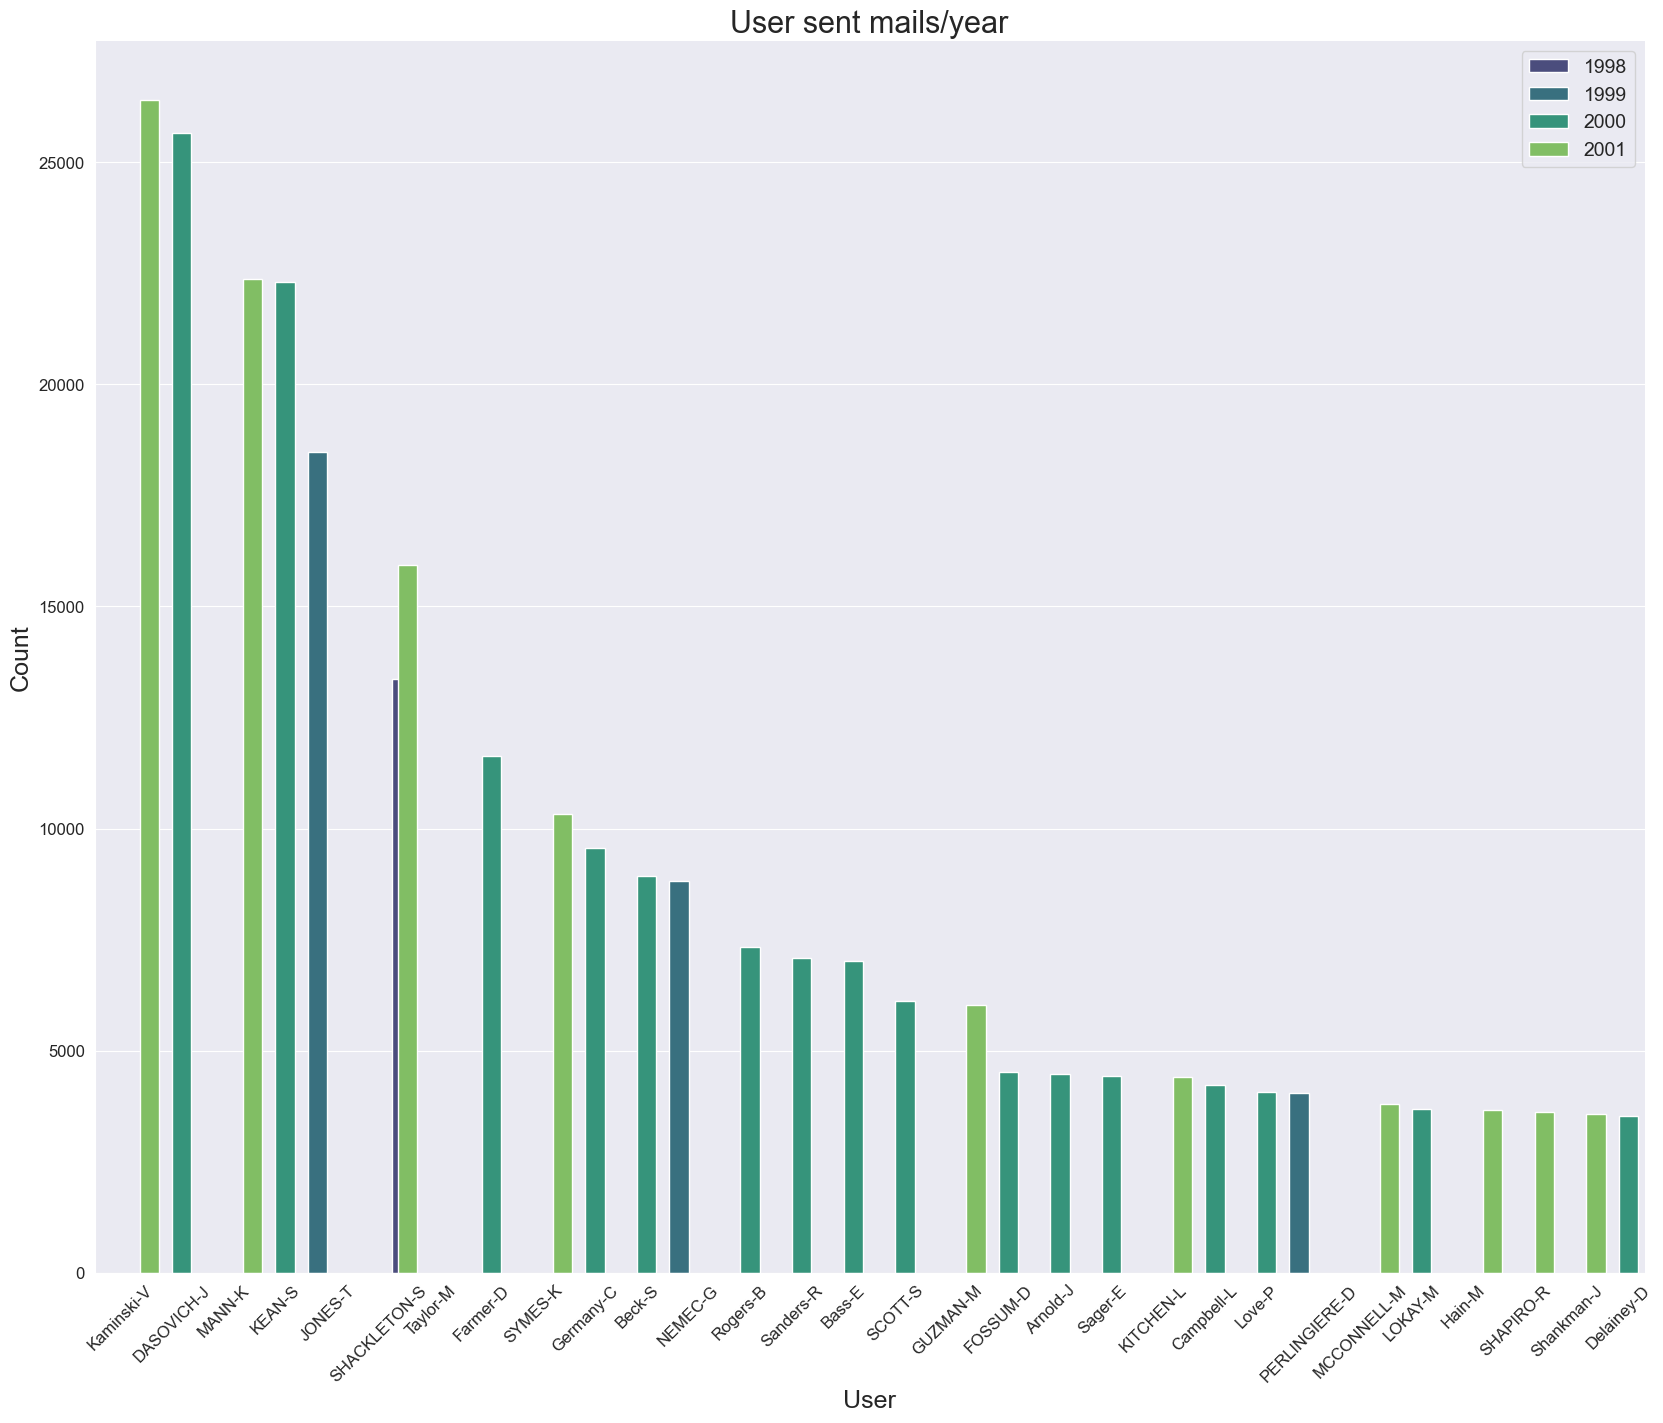

In [31]:
# diagram showing top users and count of mails sent per year
plt.figure(figsize = (20,16))
ax = sns.barplot(data = dataf, x ='User', y = 'Count', hue = 'Year', palette = 'viridis' , saturation = 0.7, width = 1.5)
sns.despine()
plt.xlabel('User', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('User sent mails/year', fontsize = 22)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

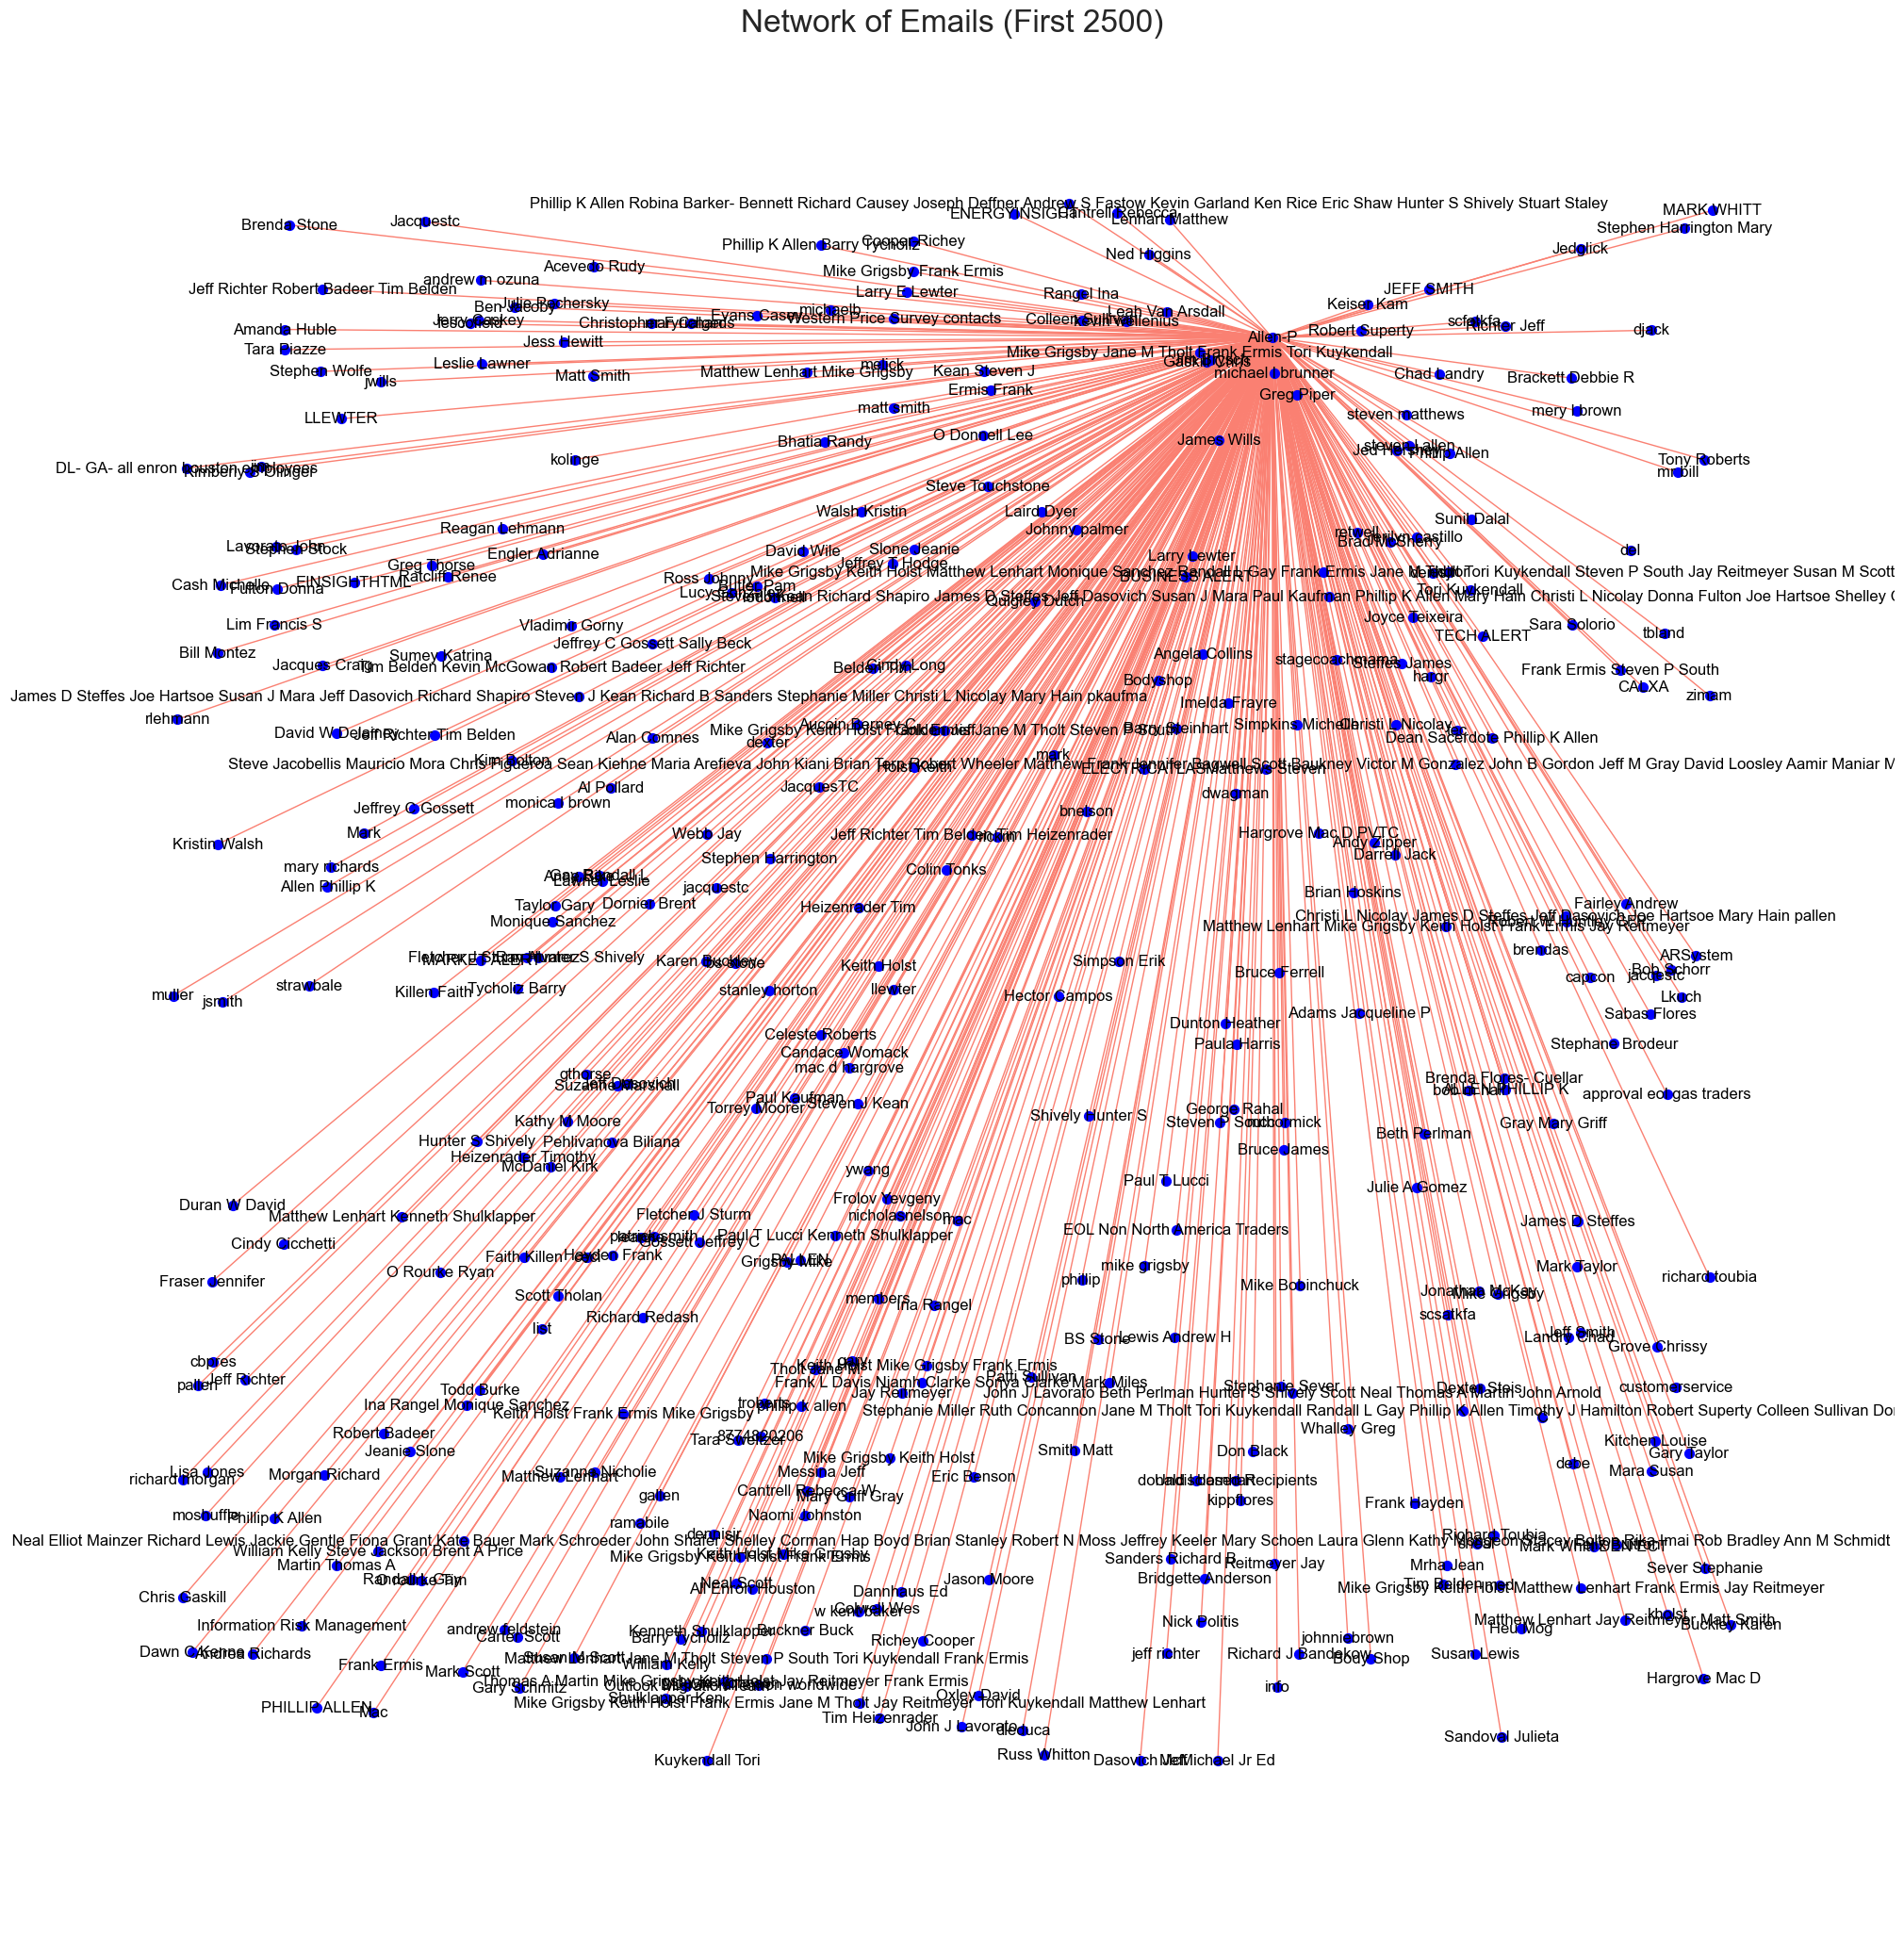

In [32]:
# a network of first 2500 rows showing the network of Allen P
plt.figure(figsize = (20, 20))
G = nx.from_pandas_edgelist(df[:2500], 'X-Origin', 'X-To')
pos = nx.draw_random(G, node_size = 50, node_color = 'blue', edge_color = 'salmon', with_labels = True)
plt.title('Network of Emails (First 2500)', fontsize = 24)
plt.show()

**Machine Learning and NLP on the dataset**

In [33]:
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)


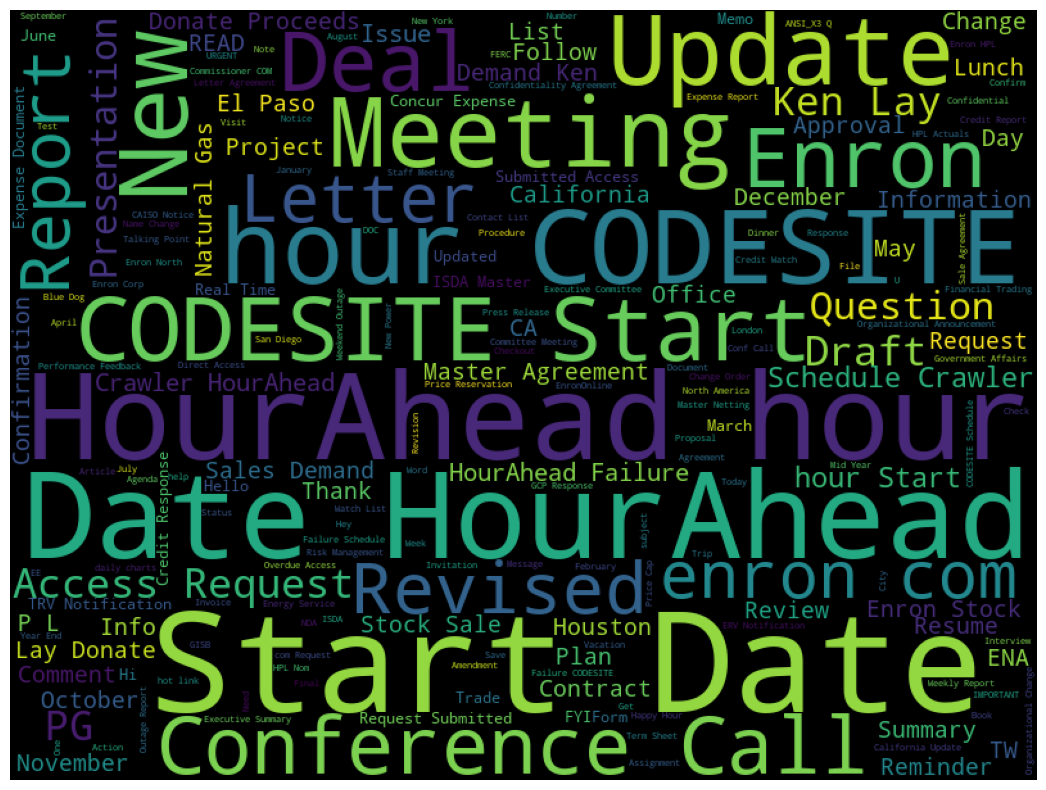

In [34]:
subjects = ' '.join(df['Subject'].values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)
ax.imshow(wc)
plt.axis('off')
plt.show()

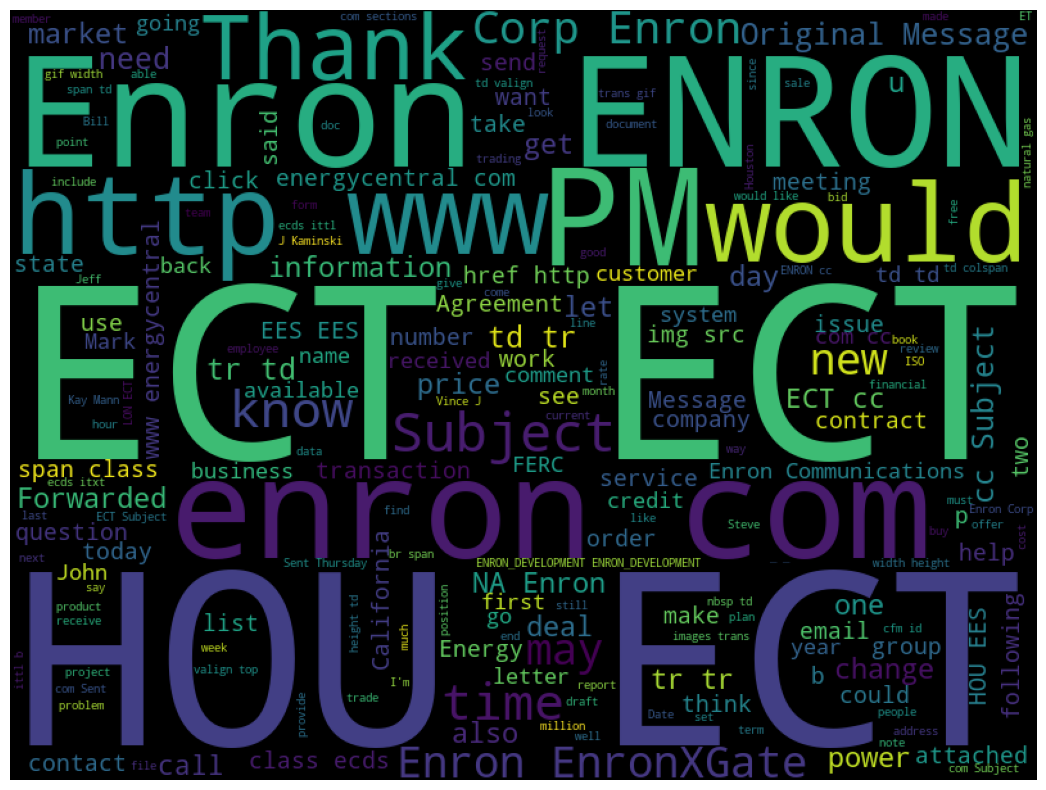

In [35]:
content = ' '.join(df['Body'].sample(1000).values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(content)
ax.imshow(wc)
plt.axis('off')
plt.show()

In [36]:
# function for cleaning the body text
def cleaningbody(col):
    msgcol = []
    for msg in col.values:
        msg = re.sub(r'[<>\n+\t+\s+\*]', ' ', msg)
        msg = re.sub(r'[0-9]+[a-zA-Z]+\d+[?!].DOC', ' ', msg)
        msg = re.sub(r'[?\s+\-+\s+?_=~]', ' ', msg)
        msg = re.sub(r' +', ' ', msg)
        msg = msg.lower().strip(' ')
        msgcol.append(msg)
    return msgcol


In [37]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

In [38]:
# Tokenizing and lemmatizing the text to prepare for classification and sentiment analysis
text = []
for msg in df['Body'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]
    
    text.append(msg_tokens)


In [39]:
text = [' '.join(message) for message in text]

In [40]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = stopwords, norm = 'l1')
data = vectorizer.fit_transform(text)


C:\Users\remoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ahead', 'eol', 'fw', 'fwd', 'please'] not in stop_words.
  warnings.warn(


In [41]:
# Normalizing the data
data_norm = normalize(data)

In [42]:
print(data_norm.shape)

(495547, 5000)


In [43]:
# Decomposition of the data and decreasing alot of features
svd = TruncatedSVD(n_components = 2, n_iter = 10, random_state = 42)
datasvd = svd.fit_transform(data_norm)

In [44]:
datasvd.shape

(495547, 2)

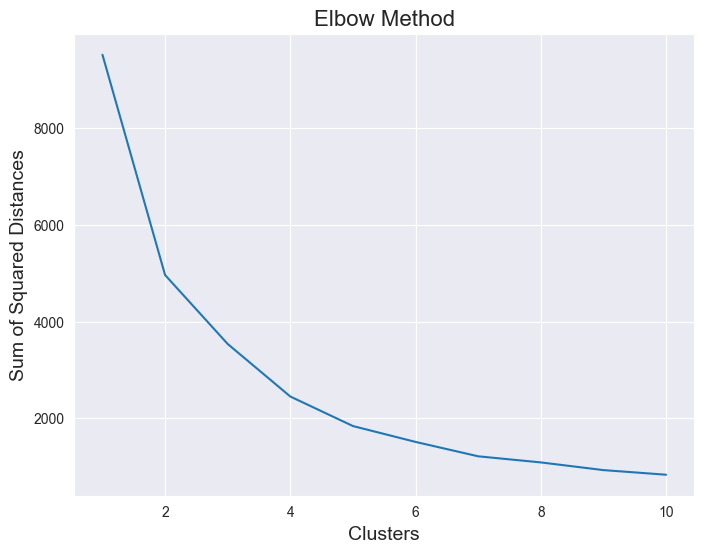

In [46]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

In [62]:
n_clusters = 6
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

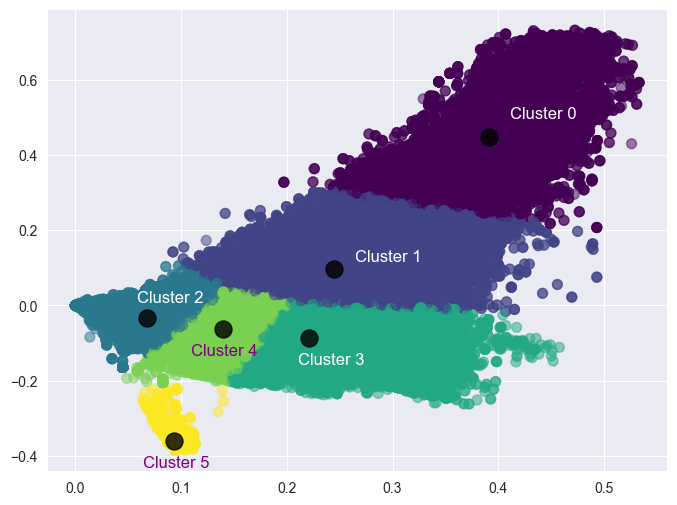

In [63]:
# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] + 0.02, centroids[0][1] + 0.05), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] + 0.02, centroids[1][1] + 0.02), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] - 0.01, centroids[2][1] + 0.04), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] - 0.01, centroids[3][1] - 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] - 0.07), color = 'purple', fontsize = 12)
plt.annotate('Cluster 5', xy = (centroids[5][0], centroids[5][1]), xytext = (centroids[5][0] - 0.03, centroids[5][1] - 0.07), color = 'purple', fontsize = 12)

plt.show()

In [64]:
# extract top words in every cluster using the inverse_transform method
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1] #(10,5000)
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
        
    print()

Cluster 0: enron please message subject http pm would thanks know sent attached schedule cc call let file may get need time 
Cluster 1: ect enron pm cc subject forwarded please thanks enronxgate mark ee deal communication know john would vince david meeting let 
Cluster 2: enron please message http subject would thanks pm sent know schedule attached final file call may let get time need 
Cluster 3: ect enron cc pm subject forwarded enronxgate ee mark communication thanks please deal david john vince tana kay sara know 
Cluster 4: enron ect please subject pm cc message thanks would know sent http attached let call need deal forwarded get may 
Cluster 5: http message schedule final variance file please detected hour hourahead date parsing ancillary awarded sent would log start energy may 


***Sentiment Analysis***

In [65]:
# praeparing the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [66]:
df['sentiment scores'] = [analyzer.polarity_scores(message) for message in text]
df.sample(5)

Date                       From  \
244078 2001-10-25 22:11:45+00:00       m..schmidt@enron.com   
268153 2000-05-26 10:03:00+00:00  rosalee.fleming@enron.com   
474624 1999-05-20 13:48:00+00:00      gilbergd@sullcrom.com   
421020 2000-04-27 10:00:00+00:00   leandro.ibasco@enron.com   
338219 2002-02-06 17:56:04+00:00       pete.davis@enron.com   

                                                       To  \
244078  karen.denne@enron.com, pr <.palmer@enron.com>,...   
268153                                 jfierro@barter.com   
474624        mark.taylor@enron.com, lkitchen@enron.co.uk   
421020                            pushkar.shahi@enron.com   
338219                               pete.davis@enron.com   

                                                  Subject           X-From  \
244078  Enron Employees Watch Their Options Devalue as...    Schmidt Ann M   
268153       Attachments to e-mail letter of May 18, 2000  Rosalee Fleming   
474624                      Electronic Trading Agreements    David Gilberg   
421020                             Question about Goldman   Leandro Ibasco   
338219                Schedule Crawler: HourAhead Failure       Davis Pete   

                                  X-To  \
244078                     Denne Karen   
268153                         jfierro   
474624  Mark ECT Legal Taylor Lkitchen   
421020                   Pushkar Shahi   
338219                      Davis Pete   

                                                 X-Folder      X-Origin  \
244078  \SKEAN (Non-Privileged)\Kean, Steven J.\Delete...        Kean-S   
268153   \Kenneth_Lay_Dec2000\Notes Folders\All documents         LAY-K   
474624  \Mark_Taylor _Dec_2000\Notes Folders\All docum...      Taylor-M   
421020  \Sara_Shackleton_Dec2000_June2001_1\Notes Fold...  SHACKLETON-S   
338219            \ExMerge - Meyers, Albert\Deleted Items      MEYERS-A   

                        X-Filename  \
244078  SKEAN (Non-Privileged).pst   
268153                    klay.nsf   
474624                 mtaylor.nsf   
421020                sshackle.nsf   
338219     bert meyers 6-25-02.PST   

                                                     Body      Employee  Year  \
244078  Enron Employees Watch Their Options Devalue as...        kean-s  2001   
268153  Mr. Fierro -\n\nI am very sorry, but I inadver...         lay-k  2000   
474624  As we discussed at our meeting, attached are p...      taylor-m  1999   
421020  Hi Pushkar,\n\nI spoke with Sara yesterday and...  shackleton-s  2000   
338219  \n\nStart Date: 2/6/02; HourAhead hour: 12;  H...      meyers-a  2002   

                                         sentiment scores  
244078  {'neg': 0.042, 'neu': 0.785, 'pos': 0.173, 'co...  
268153  {'neg': 0.073, 'neu': 0.508, 'pos': 0.418, 'co...  
474624  {'neg': 0.048, 'neu': 0.58, 'pos': 0.372, 'com...  
421020  {'neg': 0.0, 'neu': 0.81, 'pos': 0.19, 'compou...  
338219  {'neg': 0.248, 'neu': 0.752, 'pos': 0.0, 'comp...

In [67]:
# Determine the positive and negative scores
sentiment = []
for i in df['sentiment scores'].values:
    if i['compound'] > 0.05:
        sentiment.append('Positive')
    elif i['compound'] < 0.05:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['Sentiment'] = sentiment


In [68]:
sentiment_values = df['Sentiment'].value_counts()
sentiment_values

Sentiment
Positive    416462
Negative     79077
Neutral          8
Name: count, dtype: int64

In [69]:
# a graph for the sentiment as a funnel shaped graph
fig = px.funnel(sentiment_values)
fig.show()

In [72]:
# defining another function for sentiment analysis with different emotions using NRCLex lexicon
def sentiment(message):
    text = NRCLex(message)
    if text.top_emotions[0][1] == 0.0:
        return 'No Emotion'
    else:
        return text.top_emotions[0][0]
df['Emotions'] =  df['Body'].apply(sentiment)
df.sample(5)

Date                       From  \
284210 2001-04-12 10:41:00+00:00       pete.davis@enron.com   
147896 2001-03-04 15:37:00+00:00       pete.davis@enron.com   
100892 2000-06-04 16:26:00+00:00     robert.lloyd@enron.com   
247668 2001-06-12 07:37:00+00:00  richard.shapiro@enron.com   
308500 2001-05-07 11:52:00+00:00    stuart.zisman@enron.com   

                                                       To  \
284210                               pete.davis@enron.com   
147896                               pete.davis@enron.com   
100892  robert.cotten@enron.com, jackie.young@enron.co...   
247668                              steven.kean@enron.com   
308500                                 kay.mann@enron.com   

                                                  Subject            X-From  \
284210  Start Date: 4/12/01; HourAhead hour: 11;  <COD...  Schedule Crawler   
147896  Start Date: 3/4/01; HourAhead hour: 16;  <CODE...  Schedule Crawler   
100892        Weekend Activity Dated: June 2 thru June4th    Robert E Lloyd   
247668                                          Hertzberg   Richard Shapiro   
308500                                Haywood Transaction     Stuart Zisman   

                                                     X-To  \
284210                                         pete davis   
147896                                         pete davis   
100892  Robert Cotten Jackie Young Charlotte Hawkins C...   
247668                                      Steven J Kean   
308500                                           Kay Mann   

                                                 X-Folder  X-Origin  \
284210     \eric linder 6-28-02\Notes Folders\Notes inbox  LINDER-E   
147896   \mark guzman 6-28-02\Notes Folders\All documents  GUZMAN-M   
100892  \Darren_Farmer_Dec2000\Notes Folders\All docum...  Farmer-D   
247668  \Steven_Kean_Nov2001_4\Notes Folders\Discussio...    KEAN-S   
308500   \Kay_Mann_June2001_1\Notes Folders\All documents    MANN-K   

                     X-Filename  \
284210  eric linder 6-28-02.nsf   
147896  mark guzman 6-28-02.nsf   
100892              dfarmer.nsf   
247668                skean.nsf   
308500                kmann.nsf   

                                                     Body  Employee  Year  \
284210  Start Date: 4/12/01; HourAhead hour: 11;  No a...  linder-e  2001   
147896  Start Date: 3/4/01; HourAhead hour: 16;  No an...  guzman-m  2001   
100892    \n Friday Night  --6:45 pm:\n   \n \nSherry ...  farmer-d  2000   
247668  ---------------------- Forwarded by Richard Sh...    kean-s  2001   
308500  I have reviewed the latest revisions to the tw...    mann-k  2001   

                                         sentiment scores Sentiment  \
284210  {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...  Positive   
147896  {'neg': 0.0, 'neu': 0.867, 'pos': 0.133, 'comp...  Positive   
100892  {'neg': 0.062, 'neu': 0.875, 'pos': 0.062, 'co...  Negative   
247668  {'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'comp...  Positive   
308500  {'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'comp...  Positive   

          Emotions  
284210  No Emotion  
147896       trust  
100892    positive  
247668       trust  
308500       trust

In [73]:
emotions = df['Emotions'].value_counts()
emotion_chart = pd.DataFrame(emotions)
emotion_chart = emotion_chart.drop('No Emotion', axis = 0)
emotion_chart

count
Emotions            
positive      268610
trust          71311
anticipation   34016
negative       22330
fear           16268
surprise        5359
anger           3663
sadness          707
disgust           80
joy               50

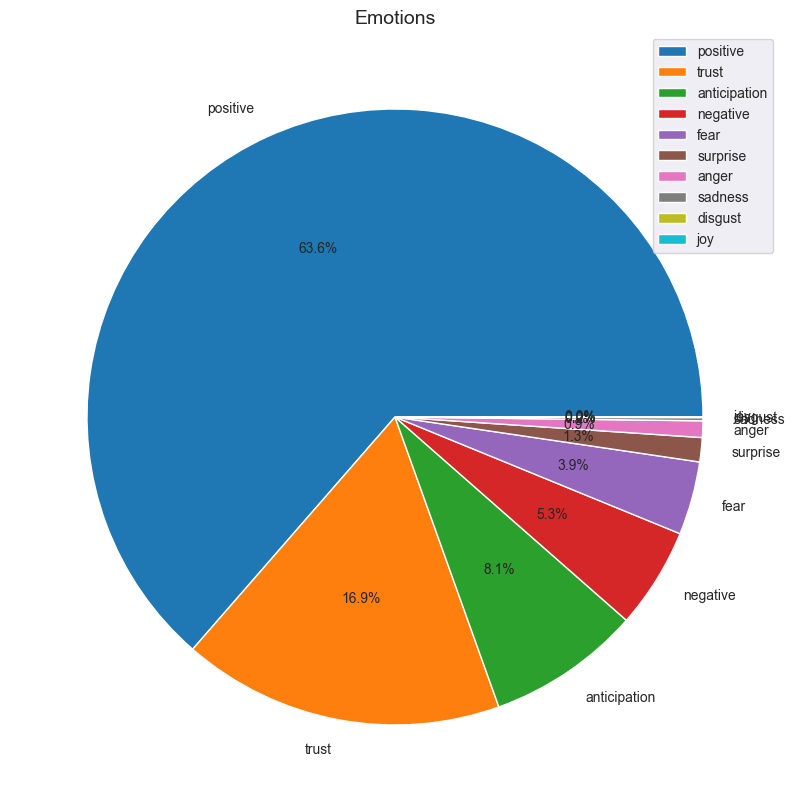

In [74]:
# A pie chart for showing the percentage of every emotion in the text
labels = emotion_chart.index.tolist()
plt.figure(figsize = (10,10))
plt.pie(emotion_chart['count'].values, labels = labels , autopct = '%1.1f%%', labeldistance= 1.1)
plt.title('Emotions', fontsize = 14)
plt.legend()
plt.show()